In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
import pytz

In [2]:
csv = "/Users/dan/Documents/Finance/Programs/Financial Machine Learning/Backtesting/ES-Trades-During-Market-Hours.csv"
df = pd.read_csv(csv)

Add a date column to easily identify date changes. 

In [3]:
df['date'] = pd.to_datetime(df['time'], unit='s').dt.date

Verify that data has been sampled only during market hours by plotting time and observing a staircase

<Axes: >

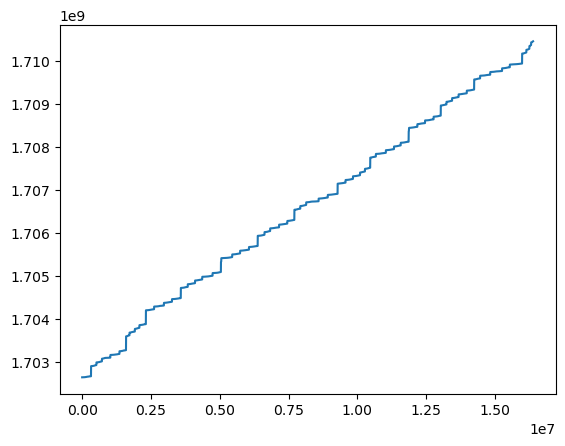

In [4]:
df.time.plot()

See which symbols are present in the df, use just ES March 2024 to backtest.
In this case, it seems we already have only march 2024 contracts. (ESH4)

In [5]:
df.symbol.unique() 

array(['ESH4'], dtype=object)

Find the start and end date. Observe that it starts 12/15/2023 9:30 am and ends 03/14/24 4:30pm

In [6]:
datetime.fromtimestamp(df.time.min()).astimezone(pytz.timezone('US/Eastern')), datetime.fromtimestamp(df.time.max()).astimezone(pytz.timezone('US/Eastern'))

(datetime.datetime(2023, 12, 15, 9, 30, 0, 526, tzinfo=<DstTzInfo 'US/Eastern' EST-1 day, 19:00:00 STD>),
 datetime.datetime(2024, 3, 14, 16, 30, 55, 940902, tzinfo=<DstTzInfo 'US/Eastern' EDT-1 day, 20:00:00 DST>))

Verify that the time column is sorted

In [7]:
df.time.is_monotonic_increasing

True

Now, let's construct bars out of the tick data. 
1. Time based bars of fixed time frames
    - 1 second
    - 5 second
    - 1 minute
    - 1 day 
    - 1 week

2. Volume bars of fixed volume
    - 100,000 contracts
    - 500,000 contracts
    - 1,000,000 contracts

3. Dollar Bars
    - $1,000,000 
    - $5,000,000
    - $10,000,000

4. Imbalance bars:
    - Tick Imbalance Bars
    - Volume Imbalance Bars
    - Dollar Imbalance Bars.


For now, I'd like to start with 5 second bars, and trade on the close of those bars. 
Having bars would also allows us to start creating features like OHLC, V, D, and others.
Need a plotting library to visualize the bars. (plotly)

In [8]:
df

,time,price,volume,symbol,date
0,1.702651e+09,4768.25,16.0,ESH4,2023-12-15
1,1.702651e+09,4768.25,3.0,ESH4,2023-12-15
2,1.702651e+09,4768.25,1.0,ESH4,2023-12-15
3,1.702651e+09,4768.25,2.0,ESH4,2023-12-15
4,1.702651e+09,4768.25,2.0,ESH4,2023-12-15
...,...,...,...,...,...
16381744,1.710448e+09,5154.25,1.0,ESH4,2024-03-14
16381745,1.710448e+09,5154.25,1.0,ESH4,2024-03-14
16381746,1.710448e+09,5154.25,3.0,ESH4,2024-03-14
16381747,1.710448e+09,5154.50,3.0,ESH4,2024-03-14


In [9]:
def time_bars(data, seconds):
    """
    Create time bars from raw tick data.
    data: pandas DataFrame with columns: time, price, volume, date
    seconds: time window for a bar in seconds
    """
    bars = []
    timer = data.time.iloc[0]  # Initialize timer at the first timestamp
    open_price = data.price.iloc[0]
    high_price = data.price.iloc[0]
    low_price = data.price.iloc[0]
    bar_volume = 0
    i = 0  # pointer to iterate over the data
    last_date = data.date.iloc[0]

    while i < len(data):
        current_date = data.date.iloc[i]

        # Check if the date has changed
        if current_date != last_date:
            # Finalize the current bar and move to the next day
            close_price = data.price.iloc[i - 1]
            bars.append((timer, open_price, high_price, low_price, close_price, bar_volume))

            # Reset the timer to the new day's start and initialize the new bar
            timer = data.time.iloc[i]  # Assuming the next bar starts with this tick
            open_price = data.price.iloc[i]
            high_price = open_price
            low_price = open_price
            bar_volume = 0
            last_date = current_date

        elif data.time.iloc[i] < timer + seconds:
            # Aggregate the data point into the current bar
            price = data.price.iloc[i]
            volume = data.volume.iloc[i]

            high_price = max(high_price, price)
            low_price = min(low_price, price)
            bar_volume += volume
            i += 1
        else:
            # Finalize the current bar
            close_price = data.price.iloc[i - 1]  # Use the last price seen
            bars.append((timer, open_price, high_price, low_price, close_price, bar_volume))

            # Advance the timer for the next bar
            timer += seconds

            # Reset for the new bar
            open_price = data.price.iloc[i]
            high_price = open_price
            low_price = open_price
            bar_volume = 0

    # Append the last bar if necessary
    if bar_volume > 0:
        close_price = data.price.iloc[i - 1]
        bars.append((timer, open_price, high_price, low_price, close_price, bar_volume))

    return pd.DataFrame(bars, columns=['time', 'open', 'high', 'low', 'close', 'volume'])

I changed my mind. Switching to bars is too much work for now. Let's keep trying backtesting. 

In [10]:
class Backtest:
    def __init__(self, df, time_increment):
        time_increment_precision = len(str(time_increment).split('.')[1])
        self.next_time = round(df.time[0], time_increment_precision)
        self.last_time = df.time[0]
        self.current_hour = datetime.fromtimestamp(self.last_time).astimezone(pytz.timezone('US/Eastern')).hour
        print(self.current_hour)
        self.current_date = df.date[0]
        self.last_price = df.price[0]
        self.results = {}
        self.daily_trades = []
        self.df = df
        self.index = 0
        self.time_increment = time_increment

        # Trading logic variables
        self.qty = 0  # Position quantity: 1 for long, -1 for short, 0 for no position

        self.leverage = 50  # Example leverage for futures trading
        self.commission = 2.25  # Commission per contract per side
        # self.tick_size = 0.25  # Fixed tick size for slippage
        self.tick_size = 0

        # profit and drawndown variables
        self.open_price = 0
        self.open_time = 0
        self.current_profit = 0  # To track the current profit
        self.current_min = float('inf') # To track the current drawdown
        self.current_max = float('-inf')  # To track the current profit high
        self.total_profit = 0  # To track the total profit made
        self.max_drawdown = 0

        self.trade_id = 0

    def tickPrice(self):
        if self.index >= len(self.df): return None

        # if index points to a new date, we need to advance the timer to the next trading day
        if self.df.date[self.index] != self.current_date:
            self.record_daily_trades()
            self.current_date = self.df.date[self.index]
            self.next_time = round(self.df.time[self.index], len(str(self.time_increment).split('.')[1]))
            self.close_all_positions()

        # Advance the index to keep last_price up to date with the sampling time
        # this will not run if the index points to a time already greater than the next sampling time
        # in which case no new price is available yet, and the previous price will be returned.
        while self.index < len(self.df) and self.df.time[self.index] <= self.next_time:
            self.last_price = self.df.price[self.index]
            self.index += 1
        
        self.last_time = self.next_time
        self.current_hour = datetime.fromtimestamp(self.last_time).astimezone(pytz.timezone('US/Eastern')).hour
        self.next_time += self.time_increment 

        return self.last_price
    
    def calculate_current_profit(self):
        if self.qty == 0:
            self.current_profit = 0
            self.current_min = float('inf')
            self.current_max = float('-inf')
            return
        
        if self.qty == 1:
            self.current_profit = (self.last_price - self.open_price) * self.leverage - self.commission * 2
        elif self.qty == -1:
            self.current_profit = (self.open_price - self.last_price) * self.leverage - self.commission * 2
            
        if self.current_profit < self.current_min:
            self.current_min = self.current_profit
        elif self.current_profit > self.current_max:
            self.current_max = self.current_profit

    def open_long_position(self):
        self.qty = 1
        slip_price = self.last_price + self.tick_size
        self.open_price = slip_price
        self.open_time = self.last_time
        self.daily_trades.append({"id": self.trade_id, "action": "open", "side": "buy", "fillPrice": slip_price, "time": self.last_time})

    def open_short_position(self):
        self.qty = -1
        slip_price = self.last_price - self.tick_size
        self.open_price = slip_price
        self.open_time = self.last_time
        self.daily_trades.append({"id": self.trade_id, "action": "open", "side": "sell", "fillPrice": slip_price, "time": self.last_time})

    def close_long_position(self):
        self.qty = 0
        slip_price = self.last_price - self.tick_size
        self.daily_trades.append({"id": self.trade_id, "action": "close", "side": "sell", "fillPrice": slip_price, "time": self.last_time, "profit": self.current_profit, "profit_low": self.current_min, "profit_high": self.current_max})
        self.trade_id += 1
        
    def close_short_position(self):
        self.qty = 0
        slip_price = self.last_price + self.tick_size
        self.daily_trades.append({"id": self.trade_id, "action": "close", "side": "buy", "fillPrice": slip_price, "time": self.last_time, "profit": self.current_profit, "profit_low": self.current_min, "profit_high": self.current_max})
        self.trade_id += 1

    def close_all_positions(self):
        if self.qty == 1:
            # print("closing position that was opened at", self.open_time, "for", self.open_price, "at", self.last_time, "for", self.last_price)
            self.close_long_position()
        elif self.qty == -1:
            # print("closing position that was opened at", self.open_time, "for", self.open_price, "at", self.last_time, "for", self.last_price)
            self.close_short_position()
    
    def record_daily_trades(self):
        self.results[self.current_date] = self.daily_trades
        self.daily_trades = []


    

Defining the Mean-Reversion strategy

In [11]:
from collections import deque
import numpy as np

class MeanReversionStrategy:
    def __init__(self, app, boll_window=600, width=2, max_position_duration=100):
        self.app = app
        self.boll_window = boll_window
        self.width = width
        self.max_position_duration = max_position_duration
        self.prices = deque(maxlen=boll_window)
    
    def calculate_bands(self):
        mu = np.mean(self.prices)
        std = np.std(self.prices)
        upper_band = mu + self.width * std
        lower_band = mu - self.width * std
        return mu, upper_band, lower_band
    
    def tick(self):
        self.app.tickPrice()
        self.prices.append(self.app.last_price)
        self.app.calculate_current_profit()
        
        if len(self.prices) == self.boll_window:
            mu = np.mean(self.prices)
            std = np.std(self.prices)
            upper_band = mu + self.width * std
            lower_band = mu - self.width * std
            
            if self.app.qty == 0 and not self.app.current_hour >= 16: # don't open a trade after 4pm
                if self.app.last_price < lower_band - self.app.tick_size:
                    self.app.open_long_position()
                elif self.app.last_price > upper_band + self.app.tick_size:
                    self.app.open_short_position()
            elif self.app.qty == 1:
                if self.app.last_price >= mu:
                    self.app.close_long_position()
            elif self.app.qty == -1:
                if self.app.last_price <= mu:
                    self.app.close_short_position()

            if self.app.last_time - self.app.open_time > self.max_position_duration:
                self.app.close_all_positions()


In [ ]:
class TrendFollowingStrategy:
    def __init__(self, app, slow_alpha=0.05, fast_alpha=0.01):
        self.app = app
        self.slow = slow_alpha
        self.fast = fast_alpha
        self.slow_ema = app.last_price
        self.fast_ema = app.last_price

    def tick(self):
        self.app.tickPrice()
        self.app.calculate_current_profit()

        self.slow_ema = self.slow * self.app.last_price + (1 - self.slow) * self.slow_ema
        self.fast_ema = self.fast * self.app.last_price + (1 - self.fast) * self.fast_ema
        
        # use a buffer of self.app.tick_size to avoid opening and closing trades too frequently

        if self.app.qty == 0:
            if self.fast_ema > self.slow_ema + self.app.tick_size:
                self.app.open_long_position()
            elif self.fast_ema < self.slow_ema - self.app.tick_size:
                self.app.open_short_position()
        elif self.app.qty == 1:
            if self.fast_ema < self.slow_ema:
                self.app.close_long_position()
        elif self.app.qty == -1:
            if self.fast_ema > self.slow_ema:
                self.app.close_short_position()

def backtest(df, strategy, time_increment):
    app = Backtest(df, time_increment)
    strat = strategy(app)
    while app.index < len(df):
        strat.tick()
    return app.results

results = backtest(df, MeanReversionStrategy, 0.25)



In [12]:
# Running the backtest
def run_backtest(app, strategy):
    with tqdm(total=3131684) as pbar:
        while app.tickPrice() is not None:
            strategy.tick()
            pbar.update(1)

app = Backtest(df=df, time_increment=0.25)
strategy = MeanReversionStrategy(app, boll_window = 4 * 60 * 60,width=2, max_position_duration=1e20)
run_backtest(app, strategy)

# 5 minutes

9


100%|██████████| 3131684/3131684 [45:50<00:00, 1138.78it/s]


Compute backtest statistics

In [13]:
# after having run the backtest, save the results to a file

import pickle

with open('results.pickle', 'wb') as f:
    pickle.dump(app.results, f)

total_profit=-10567.5, average_daily_profit=-170.44354838709677, min_daily_profit=-4730.5, max_daily_profit=2374.5, max_drawdown=-3979.5, max_drawup=1083.0, std_of_returns=1187.492699824212


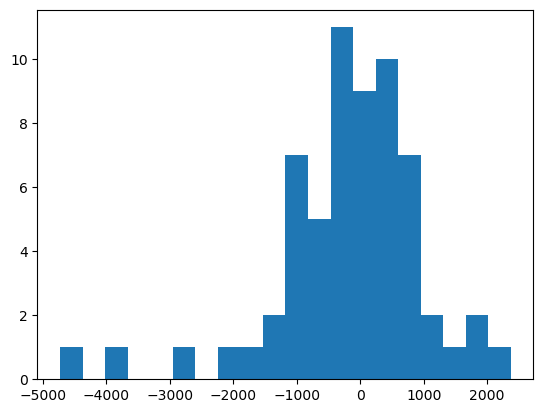

In [14]:
def compute_backtest_stats(results):
    total_profit = 0
    max_drawdown = 0
    max_drawup = 0
    average_daily_profit = 0
    min_daily_profit = 0
    max_daily_profit = 0
    daily_returns = []
    for day in results:
        daily_profit = 0
        for trade in results[day]:
            if trade["action"] == "close":
                total_profit += trade["profit"]
                if trade["profit_low"] < max_drawdown:
                    max_drawdown = trade["profit_low"]
                if trade["profit_high"] > max_drawup:
                    max_drawup = trade["profit_high"]
                daily_profit += trade["profit"]
        if daily_profit < min_daily_profit:
            min_daily_profit = daily_profit
        if daily_profit > max_daily_profit:
            max_daily_profit = daily_profit
        daily_returns.append(daily_profit)


    average_daily_profit = total_profit / len(app.results)

    print(f"{total_profit=}, {average_daily_profit=}, {min_daily_profit=}, {max_daily_profit=}, {max_drawdown=}, {max_drawup=}, std_of_returns={np.std(daily_returns)}")
    plt.hist(daily_returns, bins=20)
    plt.show()

# total_profit, max_drawdown, average_daily_profit, max_drawup
    return (total_profit, 
            max_drawdown, 
            max_drawup, 
            average_daily_profit, 
            min_daily_profit, 
            max_daily_profit, 
            daily_returns)

(total_profit,
 max_drawdown,
 max_drawup,
 average_daily_profit,
 min_daily_profit,
 max_daily_profit,
 daily_returns) = compute_backtest_stats(app.results)

<BarContainer object of 8 artists>

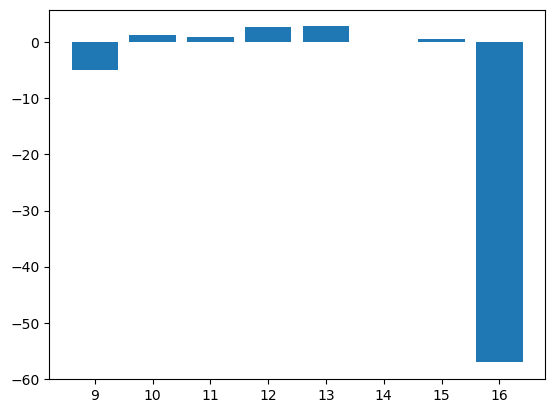

In [170]:
# Let's examine the hours of trading and the profit i make on average over each hour. 
# We can use the results dictionary to calculate this.
def hourly_backtest_stats(results):
    hourly_results = {}
    for day in results:
        for trade in results[day]:
            if trade["action"] == "close":
                hour = datetime.fromtimestamp(trade["time"]).hour
                if hour not in hourly_results:
                    hourly_results[hour] = []
                hourly_results[hour].append(trade["profit"])

    average_hourly_profit = {}
    number_of_trades_per_hour = {}
    for hour in hourly_results:
        average_hourly_profit[hour] = np.mean(hourly_results[hour])
        number_of_trades_per_hour[hour] = len(hourly_results[hour])
    return average_hourly_profit, number_of_trades_per_hour

average_hourly_profit, number_of_trades_per_hour = hourly_backtest_stats(app.results)

plt.bar(average_hourly_profit.keys(), average_hourly_profit.values())  # type: ignore


In [171]:
# get all the app.results where the sell happened after 4pm
def after4pm_backtest_stats(results):
    after_4pm = []
    for day in results:
        for trade in results[day]:
            if trade["action"] == "close":
                hour = datetime.fromtimestamp(trade["time"]).hour
                if hour >= 16:
                #we're going to append the open and close pair of trades by their ID
                    open_order = None
                    for trade2 in results[day]:
                        if trade2["id"] == trade["id"]:
                            open_order = trade2
                            break
                    after_4pm.append((open_order, trade, {"open_duration": trade["time"] - open_order["time"]}))
    return after_4pm

after_4pm = after4pm_backtest_stats(app.results)

after_4pm

[({'id': 128,
   'action': 'open',
   'side': 'buy',
   'fillPrice': 4772.0,
   'time': 1702673942.25},
  {'id': 128,
   'action': 'close',
   'side': 'sell',
   'fillPrice': 4767.75,
   'time': 1702674042.75,
   'profit': -217.0,
   'profit_low': -267.0,
   'profit_high': -4.5},
  {'open_duration': 100.5}),
 ({'id': 389,
   'action': 'open',
   'side': 'sell',
   'fillPrice': 4820.5,
   'time': 1703019584.75},
  {'id': 389,
   'action': 'close',
   'side': 'buy',
   'fillPrice': 4819.0,
   'time': 1703019675.25,
   'profit': 70.5,
   'profit_low': -54.5,
   'profit_high': 70.5},
  {'open_duration': 90.5}),
 ({'id': 762,
   'action': 'open',
   'side': 'sell',
   'fillPrice': 4805.0,
   'time': 1703278768.5},
  {'id': 762,
   'action': 'close',
   'side': 'buy',
   'fillPrice': 4806.75,
   'time': 1703278869.0,
   'profit': -92.0,
   'profit_low': -154.5,
   'profit_high': 45.5},
  {'open_duration': 100.5}),
 ({'id': 877,
   'action': 'open',
   'side': 'sell',
   'fillPrice': 4825.5,


In [172]:
def plot_duration_vs_profit(results):
    # Let's plot trade duration vs profit
    trade_durations = []
    trade_profits = []

    # we're gonna iterate all the trades. When we find one that is a close; we match up the id to the open trade and calculate the duration
    # the close trading will have the profit. Also, the open trade will precede the close trade in the list, so we just need to track the current open trade id
    current_open_trade = None
    for day in results:
        for trade in results[day]:
            if trade["action"] == "open":
                current_open_trade = trade
            elif trade["action"] == "close":
                trade_durations.append(trade["time"] - current_open_trade["time"])
                trade_profits.append(trade["profit"])

    # plt.scatter(trade_durations, trade_profits)
    #i want the positive profits to be green and the negative profits to be red
    # also decrease the point size to make it easier to see
    plt.scatter(trade_durations, trade_profits, c=["green" if x > 0 else "red" for x in trade_profits], s=1)


    profitable_trade_indices = [i for i, x in enumerate(trade_profits) if x > 0]
    profitable_trade_durations = [trade_durations[i] for i in profitable_trade_indices]
    longest_profitable_trade_duration = max(profitable_trade_durations)


    # legend
    plt.scatter([], [], c="green", s=5, label="Profitable Trade")
    plt.scatter([], [], c="red", s=5, label="Unprofitable Trade")
    plt.plot([], [], ' ', label=f"Window Size = 600")
    plt.plot([], [], ' ', label=f"Max Profitable Trade Duration = {int(longest_profitable_trade_duration)}")
    plt.legend(ncol=1, loc="lower right")

    plt.xlabel("Position Duration")
    plt.ylabel("Profit")
    plt.title("Position Duration vs. Profit")

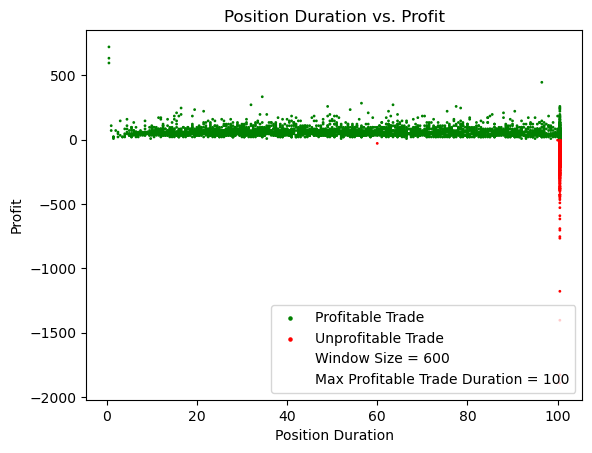

In [173]:
plot_duration_vs_profit(app.results)


In [174]:
# write a pickle of the results
import pickle

#create a paramters dictionary, then we will save the results as a touple (parameters, results)

parameters = {"boll_window": strategy.boll_window, "width": strategy.width, "max_position_duration": strategy.max_position_duration}


report ={
    "total_profit": total_profit,
    "average_daily_profit": average_daily_profit,
    "min_daily_profit": min_daily_profit,
    "max_daily_profit": max_daily_profit,
    "max_drawdown": max_drawdown,
    "max_drawup": max_drawup,
    "std_of_returns": np.std(daily_returns),
    "average_hourly_profit": average_hourly_profit,
    "number_of_trades_per_hour": number_of_trades_per_hour,
    # "longest_profitable_trade_duration": longest_profitable_trade_duration
}


results = (parameters, report, app.results)

with open(f'backtest_results/bw_{strategy.boll_window}_w_{strategy.width}_mpd_{strategy.max_position_duration}.pkl', 'wb') as f:
    pickle.dump(results, f)


Observed that every hour is negative profit. However, the 4 pm hour causes the highest loss of money. 
Need to check the minute level, or maybe 15 minute quadrants. Either way, this mean reversion strategy is not profitable over the course of any hour, on average. 

In [175]:
report

{'total_profit': 4919.5,
 'average_daily_profit': 79.34677419354838,
 'min_daily_profit': -2763.0,
 'max_daily_profit': 1826.5,
 'max_drawdown': -2217.0,
 'max_drawup': 508.0,
 'std_of_returns': 986.0342187541517,
 'average_hourly_profit': {9: -4.9597197898423815,
  10: 1.2418273260687342,
  11: 0.864715860899067,
  12: 2.638403990024938,
  13: 2.796137339055794,
  14: 0.1075085324232082,
  15: 0.533698399326032,
  16: -57.0735294117647},
 'number_of_trades_per_hour': {9: 571,
  10: 1193,
  11: 1179,
  12: 1203,
  13: 1165,
  14: 1172,
  15: 1187,
  16: 34}}

In [176]:
# TODO: close all positions inside the strategy function; it should be aware when the day ends. 
# TODO: Add a parameter for the last time of day you would be willing to trade. 
# TODO: incorporate slippage into the strategy

#Observation: Closing position on day end currently doesn't solve our profit problem. in fact it gets slightly worse. 
# TODO: Plot profit curve per hour of the day. See if there are hours when the strategy is more profitable.

#TODO: Measure bollinger width when profitable vs when unprofitable. Also measure the distance of the entry price from the mean. 

In [177]:
daily_returns

[869.5,
 717.5,
 245.5,
 -1526.0,
 -2211.5,
 -728.5,
 107.5,
 679.0,
 1443.5,
 1143.0,
 -829.5,
 -931.0,
 1548.0,
 -353.5,
 -69.0,
 -382.0,
 -452.5,
 -825.0,
 -38.0,
 862.5,
 932.0,
 611.5,
 783.0,
 1439.5,
 1826.5,
 1222.0,
 179.5,
 362.5,
 -34.5,
 -825.5,
 1286.5,
 -709.0,
 -793.0,
 -1244.5,
 -653.5,
 675.0,
 -677.0,
 1381.0,
 1059.0,
 1031.0,
 -623.5,
 -221.5,
 654.5,
 -69.5,
 286.0,
 -1017.0,
 43.0,
 -1002.0,
 421.5,
 -758.0,
 1161.5,
 -204.5,
 -768.0,
 1077.5,
 1136.5,
 -1622.0,
 -499.5,
 914.0,
 776.5,
 -558.0,
 -2763.0,
 1433.5]